# Pre-Process
## Packages 

In [1]:
! pip install -q yfinance pandas mplfinance datetime

In [2]:
import yfinance as yf               # get stocks data
import pandas   as pd               # manipulate dataframes
import mplfinance as mpf            # plot stock charts
import matplotlib.pyplot as plt     # plot custom charts
from datetime import timedelta      # add days to dates
from IPython.display import HTML    # code in HTML

## Custom Functions

### Simplify df_stock

In [37]:
def simplify_df(df_in, bo_Date_is_index=True) :
    '''
    Simplifies a multi-index DataFrame & optionally resets the index.

    Args:
        df_in (pd.DataFrame):    input DataFrame from yfinance download
        bo_Date_is_index (bool): If True (default), keeps 'Date' as row index
                                 If False, replaces row index ('Date' by new 'Id')

    Returns:
        pd.DataFrame: DataFrame with simplified structure & optionally new index
    '''    
    # Characteristics of df_in
    print('Column indexes of df_in  : ', df_in.columns.names)
    print('Row indexes    of df_in  : ', df_in.index.name)

    # Convert float values to integer
    df_out = df_in.copy()
    df_out = df_out.astype('int')

    # Remove 1st level of column names
    li_new_columns = list(df_in.columns.get_level_values(0))
    df_out.columns = li_new_columns
    
    # Optional : Replace index Date -> Id
    if not bo_Date_is_index :
        df_out = df_out.reset_index()
        df_out.index.name = 'Id'

    # Characteristics of df_out
    print('Column names   of df_out : ', df_out.columns)
    print('Row indexes    of df_out : ', df_out.index.name)
    
    return df_out

### Plot Candlesticks Chart

In [38]:
def plot_chart(df_in, s_title, li_mav=[], li_addplots=[], bo_add_Volume=True, i_width=12, i_height=5) :
    '''
    Plots a candlestick chart with optional Volume.

    Args:
        df_in (pd.DataFrame): input DataFrame with index Date and columns Open, High, Low, Close, Volume
        s_title (str): chart's title
        bo_add_Volume (bool, optional): If True (default), adds a volume subplot
    '''
    mpf.plot(df_in, type='candle', title=s_title, volume=bo_add_Volume, figsize=(i_width, i_height), 
            mav=li_mav,           # moving average curves             
            addplot=li_addplots,  # append other curves in current or additional panels 
            style='yahoo'         # other styles: binance, nightclouds
    )

In [40]:
def append_macd (df_in, bo_add_Volume, li_addplots=[]) :
    '''
    Calculates 3 indicators (MACD Signal lines + MACD Histogram) and appends them to a list.

    Args:
        df_in (pd.DataFrame): input DataFrame with index Date and columns Open, High, Low, Close, Volume
        bo_add_MACD   (bool, optional): If True (default), adds 
    '''
    # Calculate MACD (trend of a trend) 
    # with ewm() = Exponential Weighted Moving average
    df_fast_average   = df_in['Close'].ewm(span=12, adjust=False).mean() 
    df_slow_average   = df_in['Close'].ewm(span=26, adjust=False).mean()
    df_fast_trend     = df_fast_average - df_slow_average
    df_slow_trend     = df_fast_trend.ewm(span=9, adjust=False).mean()
    df_trend_of_trend = df_fast_trend - df_slow_trend
    df_simpler['MACD']   = df_slow_trend
    df_simpler['Signal'] = df_fast_trend
    df_simpler['Hist_pos']   = df_trend_of_trend.map(lambda x: x if x > 0 else 0)
    df_simpler['Hist_neg']   = df_trend_of_trend.map(lambda x: x if x < 0 else 0)

    # Append MACD curves to chart 
    if bo_add_Volume :  hist_panel = 2
    else             :  hist_panel = 1
    signal_panel = hist_panel + 1
    li_addplots = [        
        mpf.make_addplot(df_in[['Hist_pos']], type='bar',  panel=hist_panel,   ylabel='Histogram', color='green'),
        mpf.make_addplot(df_in[['Hist_neg']], type='bar',  panel=hist_panel,   ylabel='Histogram', color='red'  ),
        mpf.make_addplot(df_in[['MACD']]    , type='line', panel=signal_panel, ylabel='MACD',      color='gray'),
        mpf.make_addplot(df_in[['Signal']]  , type='line', panel=signal_panel, ylabel='Signal',    color='orange')
    ]
    return li_addplots

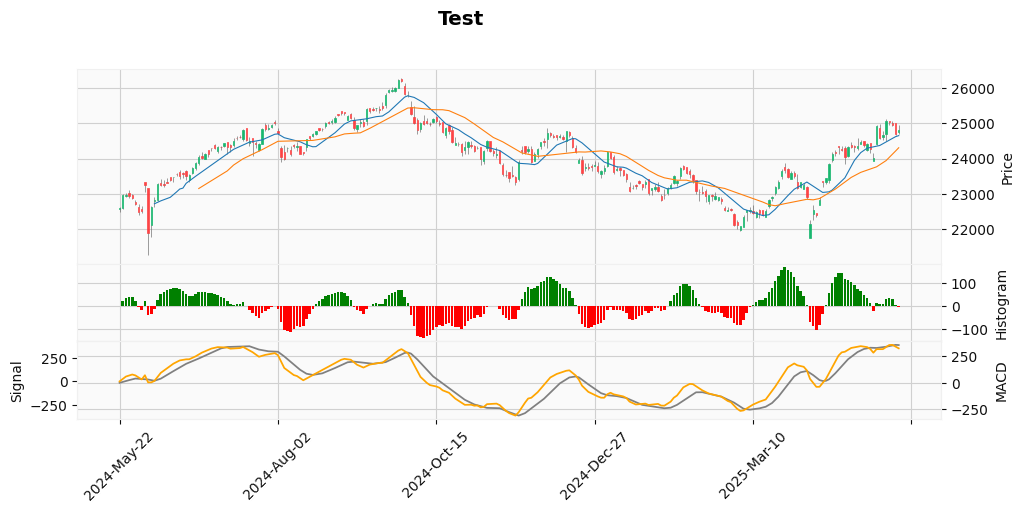

In [54]:
s_title='Test'
li_mav=[12, 26]
li_addplots = []
li_addplots=append_macd(df_simpler, bo_add_Volume)
bo_add_Volume=False
plot_chart(df_simpler, s_title, li_mav, li_addplots, bo_add_Volume=bo_add_Volume)

In [34]:
def add_plot_to_chart(df_in, s_title, bo_add_Volume=True, bo_add_MACD=True, s_width=12, s_height=5) :
    '''
    Plots a candlestick chart with optional Volume and MACD indicators.

    Args:
        df_in (pd.DataFrame): input DataFrame with index Date and columns Open, High, Low, Close, Volume
        s_title (str): chart's title
        bo_add_Volume (bool, optional): If True (default), adds a volume subplot
        bo_add_MACD   (bool, optional): If True (default), adds MACD & Signal lines + MACD Histogram
    '''
    li_addplots = []
    hist_panel = 1 
    
    if bo_add_MACD :    
        
        # Calculate MACD (trend of a trend) 
        # with ewm() = Exponential Weighted Moving average
        df_fast_average   = df_in['Close'].ewm(span=12, adjust=False).mean() 
        df_slow_average   = df_in['Close'].ewm(span=26, adjust=False).mean()
        df_fast_trend     = df_fast_average - df_slow_average
        df_slow_trend     = df_fast_trend.ewm(span=9, adjust=False).mean()
        df_trend_of_trend = df_fast_trend - df_slow_trend
        df_simpler['MACD']   = df_slow_trend
        df_simpler['Signal'] = df_fast_trend
        df_simpler['Hist_pos']   = df_trend_of_trend.map(lambda x: x if x > 0 else 0)
        df_simpler['Hist_neg']   = df_trend_of_trend.map(lambda x: x if x < 0 else 0)
    
        # Append MACD curves to chart 
        if bo_add_Volume :  hist_panel += 1
        li_addplots = [        
            mpf.make_addplot(df_in[['Hist_pos']], type='bar',  panel=hist_panel,   ylabel='Histogram', color='green'),
            mpf.make_addplot(df_in[['Hist_neg']], type='bar',  panel=hist_panel,   ylabel='Histogram', color='red'  ),
            mpf.make_addplot(df_in[['MACD']]    , type='line', panel=hist_panel+1, ylabel='MACD',      color='gray'),
            mpf.make_addplot(df_in[['Signal']]  , type='line', panel=hist_panel+1, ylabel='Signal',    color='orange')
    ]

    # Plot chart
    mpf.plot(df_in, type='candle', title=s_title, volume=bo_add_Volume, style='yahoo', # other styles: binance, nightclouds 
            mav=(12, 26),           # moving average curves
            figsize=(s_width, s_height), 
            addplot=li_addplots)   # append MACD curves

# Main Process

## Load

In [5]:
s_stock_ref   = '^NSEI' # Nifty 50
s_interval    = '1d'
s_start_date  = '2024-05-22'
s_end_date    = '2025-05-22'
df_stocks = yf.download(s_stock_ref, interval=s_interval, start=s_start_date, end=s_end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## Format

In [6]:
df_simpler = simplify_df(df_stocks) #, False)

Column indexes of df_in  :  ['Price', 'Ticker']
Row indexes    of df_in  :  Date
Column names   of df_out :  Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Row indexes    of df_out :  Date


In [7]:
df_simpler.head(1)

,Close,High,Low,Open,Volume
Date,,,,,
2024-05-22,22597,22629,22483,22576,290300


## Visualisation
### Plot Chart

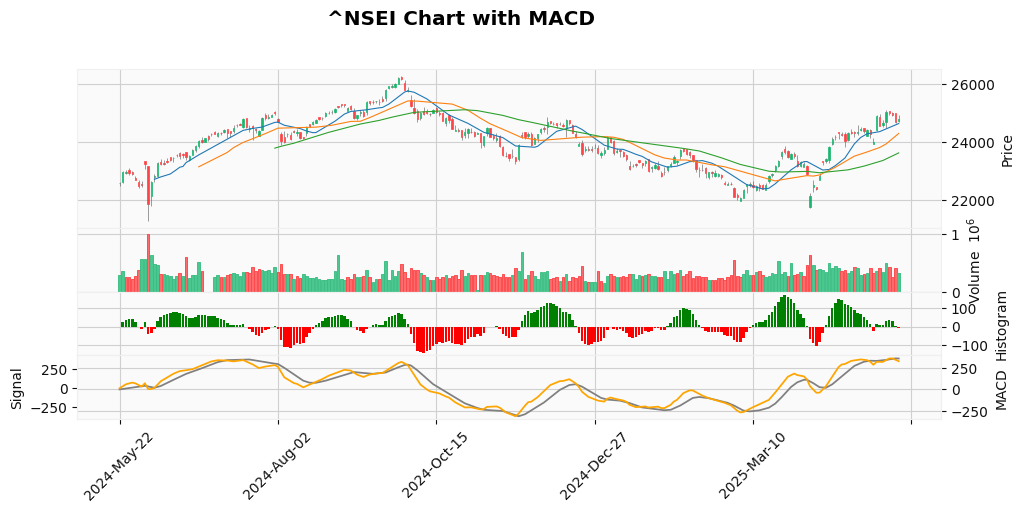

In [35]:
s_title = s_stock_ref + ' Chart with MACD'
add_plot_to_chart(df_simpler, s_title)

## Pattern Detection

### Candlesticks
#### Doji

<img src='https://img.investingoal.com/app/uploads/2024/11/long-legged-doji-candlestick-pattern.jpg' width='400px'>

In [9]:
def is_doji(trade) : # A Doji's body is much smaller than its range
    #open_, close, high, low = trade['Open'], trade['Close'], trade['High'], trade['Low']
    open_, close, high, low = trade[['Open', 'Close', 'High', 'Low']]
    body   = abs(open_ - close) 
    range_ = high - low
    ratio_body_range = 0.1
    bo_is_doji = ( body <= ratio_body_range * range_ )
    return bo_is_doji
# Append column Doji
df_simpler['Doji'] = df_simpler.apply(is_doji, axis=1) # 1: applies to rows

In [10]:
li_doji_dates = df_simpler[df_simpler['Doji']].index.to_list()
li_doji_dates[:5]

[Timestamp('2024-06-06 00:00:00'),
 Timestamp('2024-06-14 00:00:00'),
 Timestamp('2024-07-03 00:00:00'),
 Timestamp('2024-07-08 00:00:00'),
 Timestamp('2024-07-15 00:00:00')]

In [11]:
def plot_last_occurrence(li_dates, delta=5) : # dates range = d_last_occurrence +- delta
    d_last_occurrence = li_dates[-1]
    print('d_last_occurrence=', d_last_occurrence)
    t_delta = timedelta(days=delta)
    d_start = d_last_occurrence - t_delta
    d_end   = d_last_occurrence + t_delta
    df_subset = df_simpler.loc[d_start : d_end]
    add_plot_to_chart(df_subset, 'Last Occurrence', False, False, 7, 2)

d_last_occurrence= 2025-05-02 00:00:00


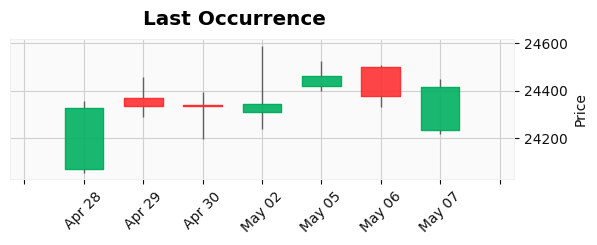

In [12]:
plot_last_occurrence(li_doji_dates)

#### Inverted Hammer

<img src='https://media.assettype.com/tnm/import/sites/default/files/images/image1%20(2)(5).png' width='400px'>

In [13]:
def get_candle_heights(trade) :
    open_, close, high, low = trade[['Open', 'Close', 'High', 'Low']]
    body       = abs(open_         - close) 
    upper_wick = high              - max(close, open_)
    lower_wick = min(close, open_) - low
    return body, upper_wick, lower_wick
    
def is_inv_hammer(trade) : # An Inverse Hammer's body is very close to its Low
    body, upper_wick, lower_wick = get_candle_heights(trade)
    ratio_up_wick_body = 2
    ratio_lo_wick_body = 0.1
    bo_is_inv_hammer = ( ( upper_wick >= ratio_up_wick_body * body ) and
                         ( lower_wick <= ratio_lo_wick_body * body ) )
    return bo_is_inv_hammer
# Append column InvHammer
df_simpler['InvHammer'] = df_simpler.apply(is_inv_hammer, axis=1) # 1: applies to rows

In [14]:
li_inv_hammer_dates = df_simpler[df_simpler['InvHammer']].index.to_list()
li_inv_hammer_dates

[Timestamp('2024-10-23 00:00:00'),
 Timestamp('2024-12-27 00:00:00'),
 Timestamp('2025-02-25 00:00:00'),
 Timestamp('2025-05-09 00:00:00')]

d_last_occurrence= 2025-05-09 00:00:00


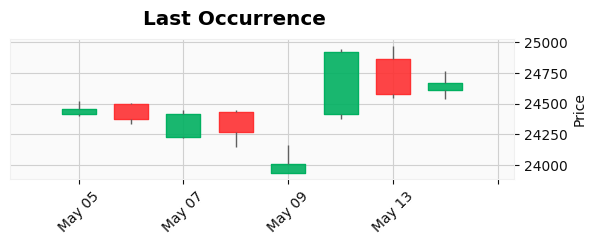

In [15]:
plot_last_occurrence(li_inv_hammer_dates)

#### Hammer

<img src='https://ninjatrader.com/getattachment/5e35b7c2-7054-4f8a-8356-f2efc79202f9/bullish-hammer-image.png' width='400px'>

In [16]:
def is_hammer(trade) : # A Hammer's body is very close to its High
    body, upper_wick, lower_wick = get_candle_heights(trade)
    ratio_up_wick_body = 0.1
    ratio_lo_wick_body = 2
    bo_is_hammer = ( ( upper_wick <= ratio_up_wick_body * body ) and
                     ( lower_wick >= ratio_lo_wick_body * body ) )
    return bo_is_hammer
# Append column InvHammer
df_simpler['Hammer'] = df_simpler.apply(is_hammer, axis=1) # 1: applies to rows

In [17]:
li_hammer_dates = df_simpler[df_simpler['Hammer']].index.to_list()
li_hammer_dates

[Timestamp('2024-06-03 00:00:00'),
 Timestamp('2025-01-08 00:00:00'),
 Timestamp('2025-04-15 00:00:00'),
 Timestamp('2025-04-23 00:00:00')]

d_last_occurrence= 2025-04-23 00:00:00


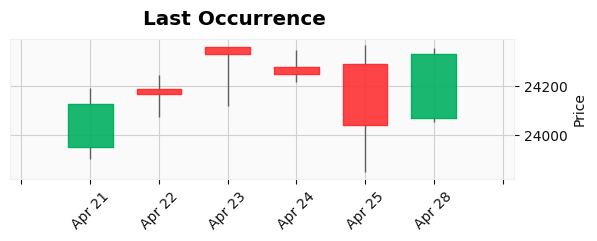

In [18]:
plot_last_occurrence(li_hammer_dates)

#### Bullish/Bearish Engulfing

In [19]:
li_main_prices = ['Open', 'Close', 'High', 'Low'] 
df_curr = df_simpler[li_main_prices].copy()
df_prev = df_curr.shift(1)
df_prev = df_prev.iloc[1:].astype('int')
df_curr = df_curr.iloc[1:]
print(df_prev.head(2))
print(df_curr.head(2))

             Open  Close   High    Low
Date                                  
2024-05-23  22576  22597  22629  22483
2024-05-24  22614  22967  22993  22577
             Open  Close   High    Low
Date                                  
2024-05-23  22614  22967  22993  22577
2024-05-24  22930  22957  23026  22908


<img src='https://fxpipsgainer.com/wp-content/uploads/2022/03/Bullish-and-Bearish-Engulfing.png' width='400px'> 

In [20]:
import numpy as np
def get_body_top   (df_in) : return np.maximum(df_in['Open'] , df_in['Close'])
def get_body_bottom(df_in) : return np.minimum(df_in['Open'] , df_in['Close'])

In [21]:
# Conditions for engulfing candles
se_high_increased   = ( df_curr['High']       > df_prev['High'] )
se_low_decreased    = ( df_prev['Low']        > df_curr['Low'] )
se_top_increased    = ( get_body_top   (df_curr) > get_body_top   (df_prev) )
se_bottom_decreased = ( get_body_bottom(df_prev) > get_body_bottom(df_curr) )
se_engulfing        = se_high_increased & se_low_decreased & se_top_increased & se_bottom_decreased

In [22]:
# Conditions for Bullish & Bearish Engulfings
se_prev_bullish     = ( df_prev['Close']      > df_prev['Open'] ) 
se_curr_bullish     = ( df_curr['Close']      > df_curr['Open'] )
se_bullish_engulf   = (  se_curr_bullish     & ~se_prev_bullish )
se_bearish_engulf   = ( ~se_curr_bullish     &  se_prev_bullish )
df_simpler['BullEngulf'] = se_engulfing & se_bullish_engulf
df_simpler['BearEngulf'] = se_engulfing & se_bearish_engulf

In [23]:
df_simpler[li_main_prices + ['BullEngulf', 'BearEngulf']].head()

,Open,Close,High,Low,BullEngulf,BearEngulf
Date,,,,,,
2024-05-22,22576,22597,22629,22483,NaN,NaN
2024-05-23,22614,22967,22993,22577,False,False
2024-05-24,22930,22957,23026,22908,False,False
2024-05-27,23038,22932,23110,22871,False,False
2024-05-28,22977,22888,22998,22858,False,False


### Summary Candlestick Chart

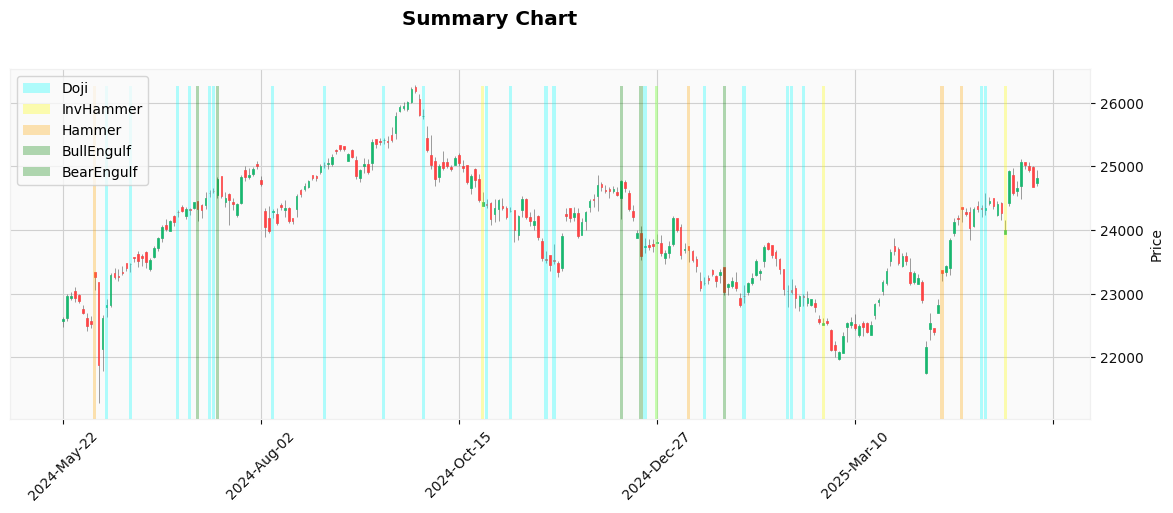

In [24]:
fig, axes = mpf.plot(
                df_simpler, type='candle', title='Summary Chart', style='yahoo', figsize=(15,5), returnfig=True,
                addplot=[   mpf.make_addplot(df_simpler[['Doji']]     , type='bar', color='cyan',   alpha=0.3, label='Doji'),
                            mpf.make_addplot(df_simpler[['InvHammer']], type='bar', color='yellow', alpha=0.3, label='InvHammer'),
                            mpf.make_addplot(df_simpler[['Hammer']],    type='bar', color='orange', alpha=0.3, label='Hammer'),
                            mpf.make_addplot(df_simpler[['BullEngulf']],    type='bar', color='green', alpha=0.3, label='BullEngulf'),
                            mpf.make_addplot(df_simpler[['BearEngulf']],    type='bar', color='green', alpha=0.3, label='BearEngulf') ]
                )
axes[1].set_yticks([])
axes[1].legend(loc='upper left')
plt.show()

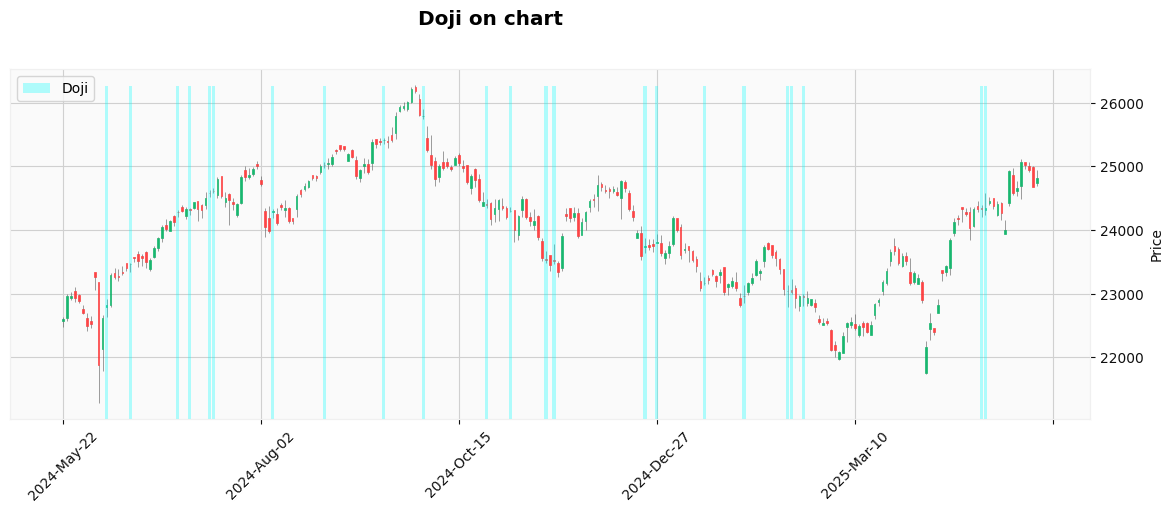

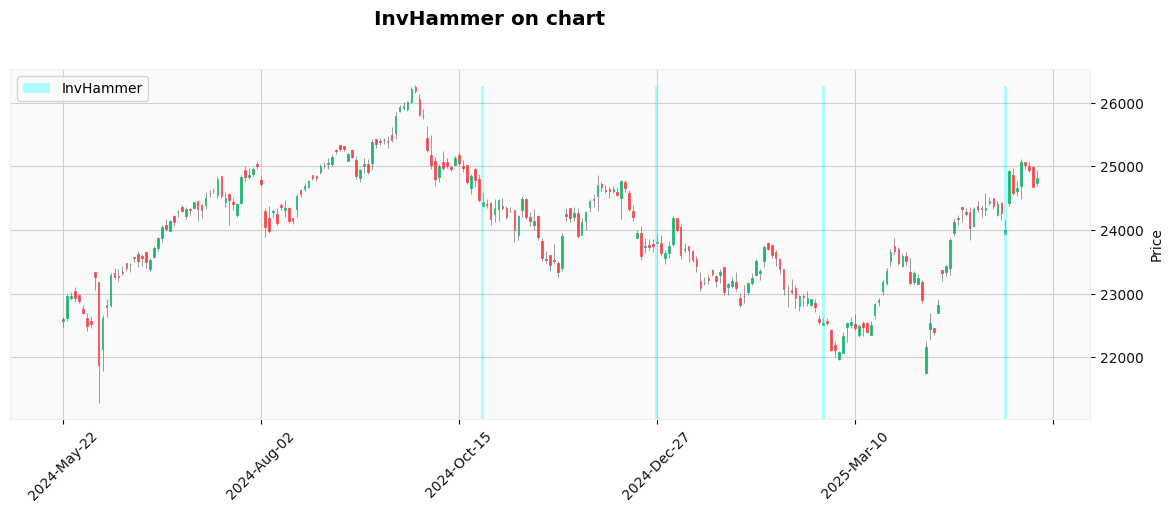

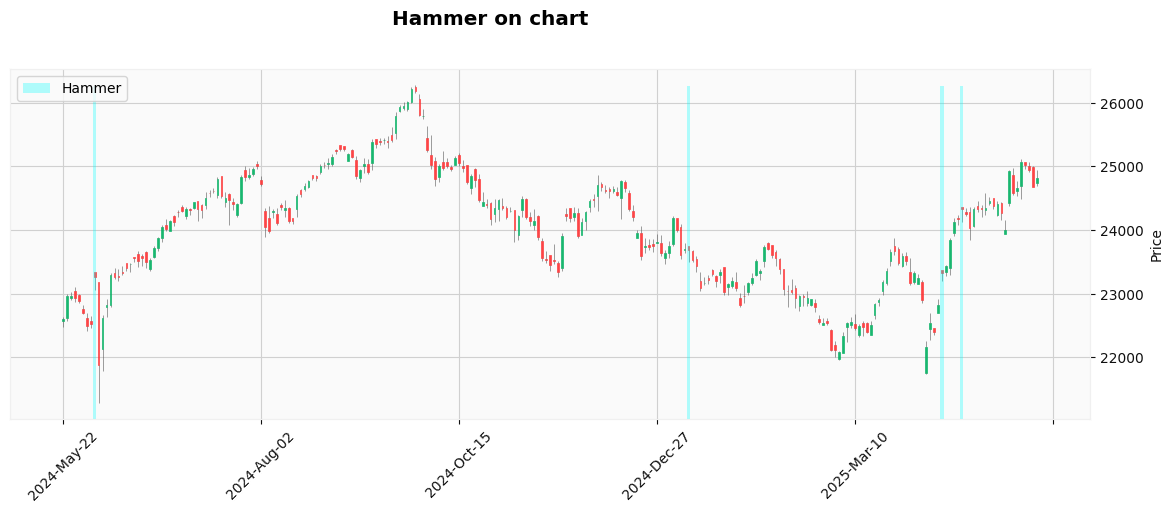

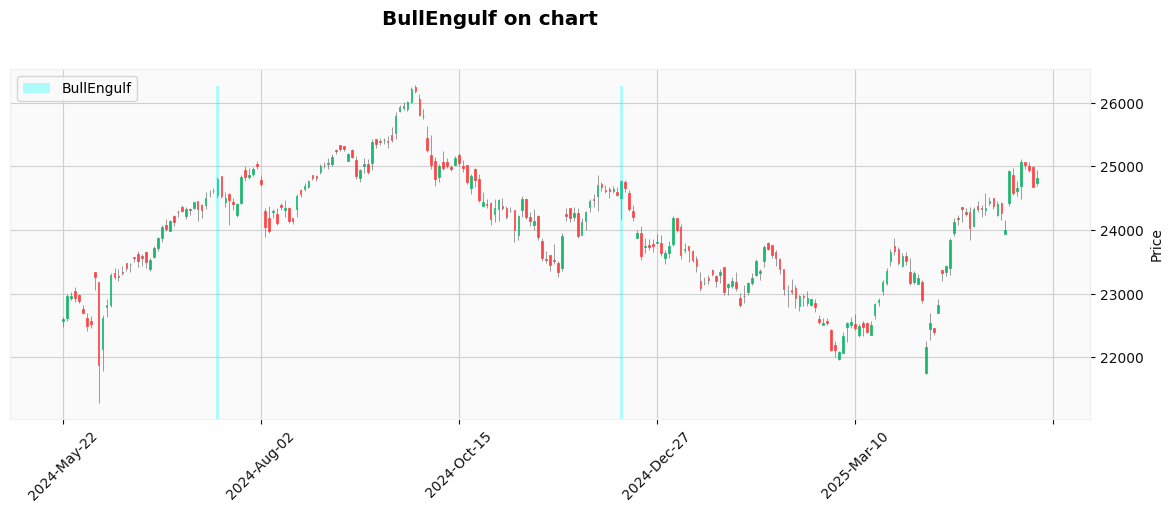

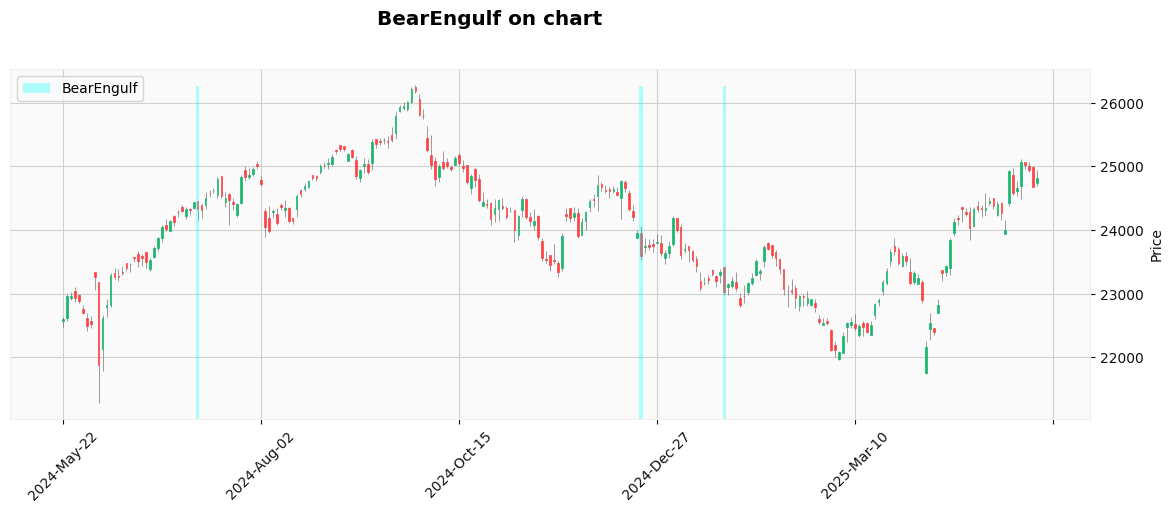

In [25]:
def plot_pattern_on_chart(s_pattern) :
    s_title = s_pattern + ' on chart'
    fig, axes = mpf.plot(
                df_simpler, type='candle', title=s_title, style='yahoo', figsize=(15,5), returnfig=True,
                addplot=[   mpf.make_addplot(df_simpler[[s_pattern]], type='bar', color='cyan', alpha=0.3, label=s_pattern) ]
                )
    axes[1].set_yticks([])
    axes[1].legend(loc='upper left')
for s_pattern in ['Doji', 'InvHammer', 'Hammer', 'BullEngulf', 'BearEngulf'] :
    plot_pattern_on_chart(s_pattern)
plt.show()